# **Caso Práctico 1: Análisis de Red de Bicicletas**
El documento corresponde a un caso práctico que puede ser utilizado como guía para aplicar Network Analysis en casos prácticos reales.

### **Contexto práctico**

El análisis de redes (Network Analysis) es una herramienta poderosa para comprender la estructura y función de sistemas complejos en los cuales los datos muestran interacciones entre sí. Una red de bicicletas compartidas es un servicio de transporte en el que las bicicletas están disponibles para uso compartido por personas a bajo costo. El uso compartido de bicicletas proporciona acceso gratuito o asequible a bicicletas para viajes de corta distancia en un área urbana como alternativa a los vehículos privados, reduciendo así la congestión, el ruido y la contaminación del aire. Los datos utilizados en este caso de uso provienen del registro viajes realizados en la red de bicicletas compartidas de la ciudad de San Francisco. En este caso se tiene el registro de las estaciones de inicio y de fin de cada viaje realizado en las bicicletas de la red. El objetivo es entender los patrones de transporte en la red que permitan resolver las siguientes preguntas puntuales:
- ¿Cuál es el número único de estaciones y rutas?
- ¿Cuales son las estacionas más comunes de inicio y fin?
- ¿Cuál es la ruta más común por número de viajes?
- ¿Cuál es la estación más importante?
- ¿Cuántas comunidades se pueden reconocer en la red?

### **Descripción de los datos**

Los datos corresponden a 11 variables:

- **iD**: identificador único del viaje.
- **duration**: duración del viaje.
- **start_date**: fecha de inicio del viaje.
- **start_station_name**: nombre de la estación de inicio.
- **start_station_id**: identificador único de la estación de inicio.
- **end_date**: fecha de fin del viaje.
- **end_station_name**: nombre de la estación de fin.
- **end_station_id**: identificador único de la estación de fin.
- **bike_id**: identificador único de la bicicleta.
- **subscription_type**: tipo de suscripción del cliente.
- **zip_code**: código zip.
- **start_station_lat**: latitud de la estación de inicio.
- **start_station_long**: longitud de la estación de inicio.
- **end_station_lat**: latitud de la estación de fin.
- **end_station_long**: longitud de la estación de inicio.

Las variables relevantes para nuestro análisis serán: "start_station_id" y "end_station_id".

## **1. Configuración Inicial y Carga de Datos**
Primero, configuraremos nuestro entorno de análisis e importaremos las bibliotecas necesarias. Despues realizaremos un preprocesamiento de datos para asignar los valores de latitud y longitud a las estaciones de inicio y de fin.

In [ ]:
# Importar librerias
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.cm as cm
import seaborn as sns
import plotly.express as px
import networkx as nx
from community import community_louvain
import os

In [ ]:
# Carga de datos
path = kagglehub.dataset_download("benhamner/sf-bay-area-bike-share")

100%|██████████| 554M/554M [00:14<00:00, 40.8MB/s]

Extracting files...


In [ ]:
# Datos de inicio y fin del viaje
df_trips = pd.read_csv(path + "/" + os.listdir(path)[1])
df_trips.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4576,63,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,8/29/2013 11:29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,8/29/2013 12:02,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103


In [ ]:
# Latitud y longitud por estación
df_loc = pd.read_csv(path + "/" + os.listdir(path)[2])
df_loc.head()

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


In [ ]:
# Asignamos latitud y longitud a las estaciones de inicio y fin del viaje
column_list = ['id', 'lat', 'long']
df = (
    df_trips
    .merge(df_loc[column_list]
    .rename(columns={'id': 'start_station_id',
                     'lat': 'start_station_lat',
                     'long': 'start_station_long'}), on='start_station_id', how='left')
)

df = (
    df
    .merge(df_loc[column_list]
    .rename(columns={'id': 'end_station_id',
                     'lat': 'end_station_lat',
                     'long': 'end_station_long'}), on='end_station_id', how='left')
)

# Seleccionamos las columnas de interés y realizamos un conteo de viajes por estación
column_list = ['start_station_name', 'start_station_id', 'start_station_lat', 'start_station_long',
               'end_station_name', 'end_station_id', 'end_station_lat', 'end_station_long']
df = df[['id'] + column_list]
df = df.groupby(by=column_list).agg(trip_count=pd.NamedAgg(column="id", aggfunc="count")).reset_index()
df['route'] = df["start_station_name"].astype(str) + ' -to- ' + df["end_station_name"].astype(str)
df.head()

,start_station_name,start_station_id,start_station_lat,start_station_long,end_station_name,end_station_id,end_station_lat,end_station_long,trip_count,route
0,2nd at Folsom,62,37.785299,-122.396236,2nd at Folsom,62,37.785299,-122.396236,206,2nd at Folsom -to- 2nd at Folsom
1,2nd at Folsom,62,37.785299,-122.396236,2nd at South Park,64,37.782259,-122.392738,704,2nd at Folsom -to- 2nd at South Park
2,2nd at Folsom,62,37.785299,-122.396236,2nd at Townsend,61,37.780526,-122.390288,825,2nd at Folsom -to- 2nd at Townsend
3,2nd at Folsom,62,37.785299,-122.396236,5th at Howard,57,37.781752,-122.405127,323,2nd at Folsom -to- 5th at Howard
4,2nd at Folsom,62,37.785299,-122.396236,Beale at Market,56,37.792251,-122.397086,229,2nd at Folsom -to- Beale at Market


## **2. Análisis Inicial**
Analizaremos la información inherente al dataset para entender:
- Tipos de datos
- Valores faltantes

In [ ]:
# Tipos de datos y valores faltantes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1916 entries, 0 to 1915
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_station_name  1916 non-null   object 
 1   start_station_id    1916 non-null   int64  
 2   start_station_lat   1916 non-null   float64
 3   start_station_long  1916 non-null   float64
 4   end_station_name    1916 non-null   object 
 5   end_station_id      1916 non-null   int64  
 6   end_station_lat     1916 non-null   float64
 7   end_station_long    1916 non-null   float64
 8   trip_count          1916 non-null   int64  
 9   route               1916 non-null   object 
dtypes: float64(4), int64(3), object(3)
memory usage: 149.8+ KB


#### **Insights relevantes**
- No existen datos faltantes.

## **3. Network Analysis**

Dado que las redes son representaciones de enlaces entre dos nodos, las estaciones de bicicletas podrían considerarse un nodos y cada viaje entre dos estaciones podría considerarse un enlace. Asi, crearemos una red de estaciones, misma que analizaremos utilizando métricas de centralidad. Adicional, utilizaremos el método Louvain para la detección de comunidades.



### **3.1. Análisis Exploratorio**

En esta sección abodaremos las preguntas que pueden ser respondidas utilizando anaálisis exploratorio de datos básico.

#### **3.1.1. ¿Cuál es el número única de estaciones y rutas?**

In [ ]:
# Número unico de estaciones y rutas
print("Número único de estaciones:", df['start_station_id'].nunique())
print("Número único de rutas:", df['route'].nunique())

Número único de estaciones: 70
Número único de rutas: 1916


#### **3.1.2. ¿Cuales son las estacionas más comunes de inicio y fin?**

In [ ]:
# Estaciones mas comunes de inicio y fin
df.describe(include='object')

,start_station_name,end_station_name,route
count,1916,1916,1916
unique,74,74,1916
top,Powell Street BART,San Francisco Caltrain (Townsend at 4th),2nd at Folsom -to- 2nd at Folsom
freq,39,45,1


#### **3.1.3. ¿Cuál es la ruta más común por número de viajes?**



In [ ]:
# El top 5 de rutas más comunes por número de viajes
df.sort_values(['trip_count'], ascending=False).head()

,start_station_name,start_station_id,start_station_lat,start_station_long,end_station_name,end_station_id,end_station_lat,end_station_long,trip_count,route
1396,San Francisco Caltrain 2 (330 Townsend),69,37.776600,-122.395470,Townsend at 7th,65,37.771058,-122.402717,6216,San Francisco Caltrain 2 (330 Townsend) -to- T...
711,Harry Bridges Plaza (Ferry Building),50,37.795392,-122.394203,Embarcadero at Sansome,60,37.804770,-122.403234,6164,Harry Bridges Plaza (Ferry Building) -to- Emba...
1781,Townsend at 7th,65,37.771058,-122.402717,San Francisco Caltrain (Townsend at 4th),70,37.776617,-122.395260,5041,Townsend at 7th -to- San Francisco Caltrain (T...
90,2nd at Townsend,61,37.780526,-122.390288,Harry Bridges Plaza (Ferry Building),50,37.795392,-122.394203,4839,2nd at Townsend -to- Harry Bridges Plaza (Ferr...
701,Harry Bridges Plaza (Ferry Building),50,37.795392,-122.394203,2nd at Townsend,61,37.780526,-122.390288,4357,Harry Bridges Plaza (Ferry Building) -to- 2nd ...


In [ ]:
# Representamos las estaciones en el mapa de San Francisco
fig = px.scatter_mapbox(df_loc, lat='lat', lon='long', zoom=9,
                        mapbox_style="carto-positron", height=700,
                        hover_name='name', color_discrete_sequence=['blue'],
                       title="Mapa de la Red de Bicicletas en San Francisco",opacity=0.5)
fig.update_layout(scattergap=0)
fig.show()

La imagen muestra un mapa de la red de bicicletas en San Francisco. Se puede observar que la mayor concentración de rutas para bicicletas (marcadas en azul) está en el centro de San Francisco, formando un núcleo denso de infraestructura ciclista.

**Insights relevantes**

- La infraestructura ciclista está principalmente concentrada en el centro de San Francisco, con muy pocas conexiones hacia las zonas del sur como South San Francisco, San Mateo y más allá.
- Se notan pequeños puntos azules en ciudades satélite como Palo Alto, Mountain View y San José, lo que sugiere la existencia de redes ciclistas locales pero con limitada conectividad entre ellas.
- Las áreas de la Bahía Este como Oakland y Berkeley parecen tener una menor infraestructura ciclista comparada con San Francisco.
- La geografía de la región, con la Bahía de San Francisco dividiendo las áreas urbanas, representa un desafío natural para la conectividad de la red de bicicletas entre diferentes comunidades.
- El mapa revela una oportunidad de desarrollo para expandir y conectar mejor la infraestructura ciclista entre las diferentes ciudades de la Bahía, especialmente a lo largo de la península y hacia el sur.
- Esta distribución refleja los patrones típicos de desarrollo de infraestructura ciclista en áreas metropolitanas, donde los centros urbanos densos tienden a desarrollar redes más completas mientras que las conexiones interurbanas suelen quedar subdesarrolladas.

### **3.2. Métricas de Centralidad**

En este caso iniciamos creando una representación de la red formada por estaciones y viajes. Continuaremos utilizando las métricas de centralidad para responder las preguntas propuestas.

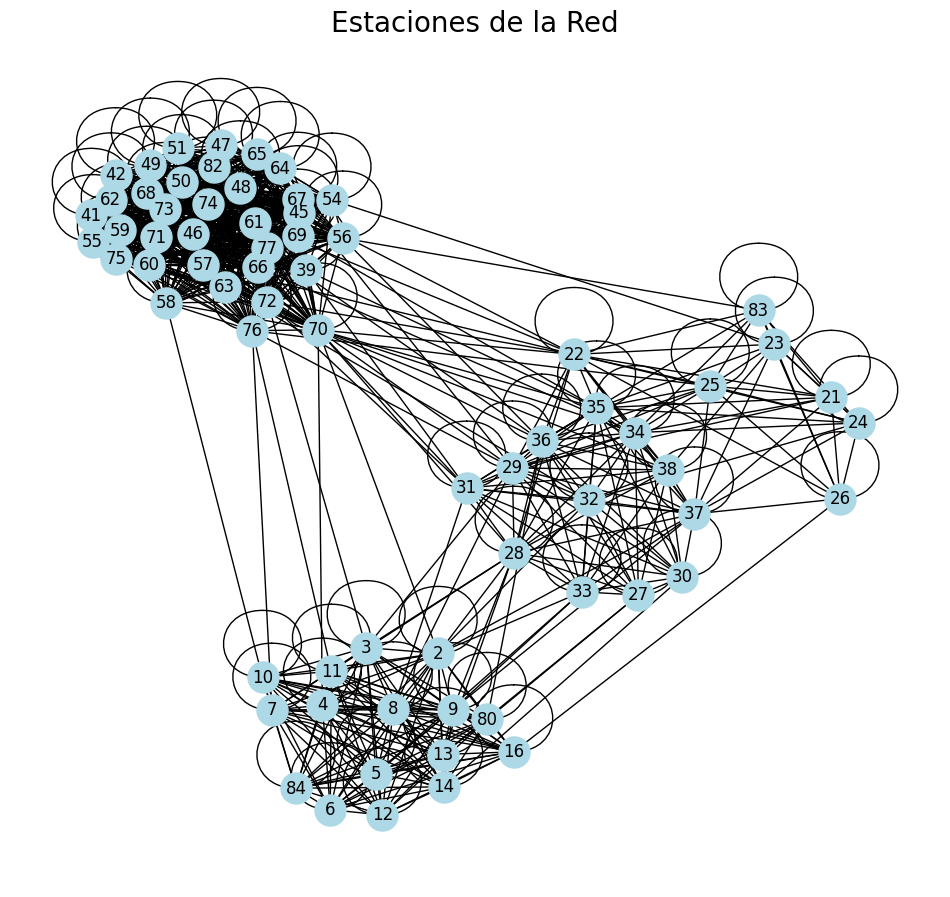

In [ ]:
# Crear y graficar red de bicicletas
G = nx.from_pandas_edgelist(df, source='start_station_id', target='end_station_id', edge_attr='trip_count', create_using=nx.Graph())
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(12, 11))
plt.title('Estaciones de la Red', fontsize=20)
plt.grid()
plt.axis('off')
nx.draw(G, with_labels=True, node_color='lightblue', node_size=500, pos=pos)
plt.show()

La imagen muestra un diagrama que representa las conexiones entre diferentes estaciones de bicicletas. El diagrama presenta tres principales agrupaciones o clústeres de estaciones:

- Un grupo grande y denso en la parte superior izquierda (estaciones con números como 41, 42, 46, 47, 49, etc.), que corresponde al centro de San Francisco.
- Un grupo en la parte inferior (estaciones 2-16, 80, 84), que representa otro distrito o zona.
- Un grupo en la parte derecha-central (estaciones 21-38), que representa otra zona de la ciudad.

**Insights relevantes**

- Existe una clara estructura de comunidades en la red, lo que sugiere que los usuarios tienden a moverse principalmente dentro de ciertas zonas geográficas de la ciudad.
- El clúster superior izquierdo es el más denso y conectado, lo que indica una mayor concentración de estaciones y uso en esa zona, probablemente el distrito financiero o centro urbano.
- Hay conexiones entre los tres grupos principales, pero son menos numerosas que las conexiones dentro de cada grupo, lo que sugiere que los viajes entre distritos son menos frecuentes.
- Algunas estaciones (como la 22, 29, 31) parecen funcionar como "puentes" entre diferentes zonas, conectando distintas partes de la red.
- La distribución de la red refleja probablemente tanto la geografía de San Francisco (con sus colinas y barrios) como los patrones de desplazamiento de los usuarios.
- La numeración no parece seguir un patrón geográfico estricto, lo que sugiere que las estaciones se han ido añadiendo a la red en diferentes momentos según la demanda o disponibilidad.
- Este tipo de visualización es muy útil para planificar la expansión de la red, identificar estaciones críticas para el mantenimiento, y comprender los patrones de movilidad urbana en bicicleta.

#### **3.2.1. ¿Cuál es la estación más importante?**
Para responder esta pregunta utilizaremos las métricas de centralidad. Crearemos un score de centralidad que corresponde al promedio de las medidas de centralidad calculadas.

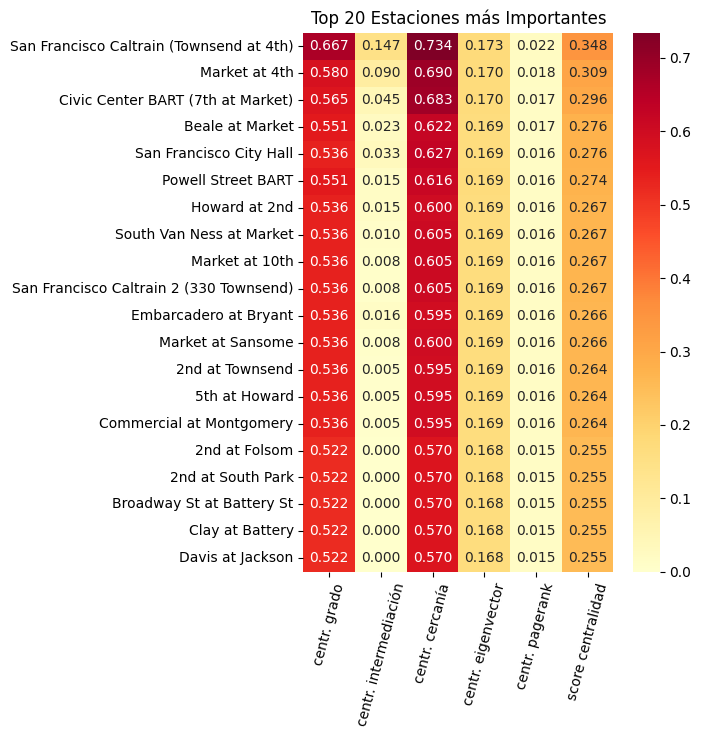

In [ ]:
def analyze_centrality(G):
    """
    Análisis completo usando múltiples métricas
    """
    # Calculamos diferentes méticas de centralidad
    metrics = {
        'centr. grado': nx.degree_centrality(G),
        'centr. intermediación': nx.betweenness_centrality(G),
        'centr. cercanía': nx.closeness_centrality(G),
        'centr. eigenvector': nx.eigenvector_centrality(G),
        'centr. pagerank': nx.pagerank(G)
    }

    # Creamos DataFrame con métricas
    centrality_df = pd.DataFrame(metrics)

    # Calculamos score compuesto
    centrality_df['score centralidad'] = centrality_df.mean(axis=1)

    return centrality_df

# Analizamos rede de bicicletas
centrality_df = analyze_centrality(G)

# Mapeamos el id al nombre de cada estación
index_map = {i: j for i, j in zip(df_loc.id, df_loc.name)}
centrality_name_df = centrality_df.rename(index=index_map)

# Visualización de top influencers
plt.figure(figsize=(5, 7))
top_stations = centrality_name_df.nlargest(20, 'score centralidad')
sns.heatmap(top_stations, cmap='YlOrRd', annot=True, fmt=".3f", annot_kws={"fontsize":10})
plt.title('Top 20 Estaciones más Importantes')
plt.xticks(rotation=75)
plt.show()

La imagen muestra un mapa de calor del sistema de bicicletas compartidas de San Francisco. La tabla presenta métricas de centralidad para las 20 estaciones más importantes de la red, con diferentes medidas representadas por colores que van desde amarillo claro (valores bajos) hasta rojo oscuro (valores altos).

- Las estaciones están listadas en orden de importancia general, con San Francisco Caltrain (Townsend at 4th) encabezando la lista.
- Las métricas incluyen: centralidad de grado, intermediación, cercanía, eigenvector, PageRank y score centralidad.
- La mayoría de las estaciones con puntuaciones altas están ubicadas en el centro financiero y distritos comerciales de San Francisco.
- Las estaciones asociadas con nodos de transporte público (Caltrain, BART) tienden a mostrar valores más altos en varias métricas.

**Insights relevantes**

- Las estaciones de conexión intermodal (como Caltrain y BART) son las más importantes de la red, lo que indica que el sistema de bicicletas funciona como complemento al transporte público.
- La estación Caltrain de Townsend at 4th destaca significativamente en centralidad de grado (0.667) e intermediación (0.147), sugiriendo que es un hub crucial para conexiones entre diferentes partes de la red.
- Las métricas de cercanía son altas y bastante uniformes en todas las estaciones principales, indicando que estas estaciones están bien conectadas y accesibles desde múltiples puntos de la red.
- Existe una clara jerarquía en la importancia de las estaciones: las primeras 5 estaciones muestran valores notablemente más altos que las demás, especialmente en centralidad de grado e intermediación.
- Las estaciones en Market Street (arteria principal de San Francisco) aparecen múltiples veces en la lista, confirmando su importancia como corredor para el tráfico ciclista.
- Las últimas 5 estaciones de la lista muestran valores idénticos en casi todas las métricas, lo que podría indicar que sirven a zonas similares o tienen patrones de uso parecidos.
- Esta información podría utilizarse para priorizar mantenimiento, expansión o reequilibrio de bicicletas, enfocando recursos en las estaciones más críticas para el funcionamiento de la red.

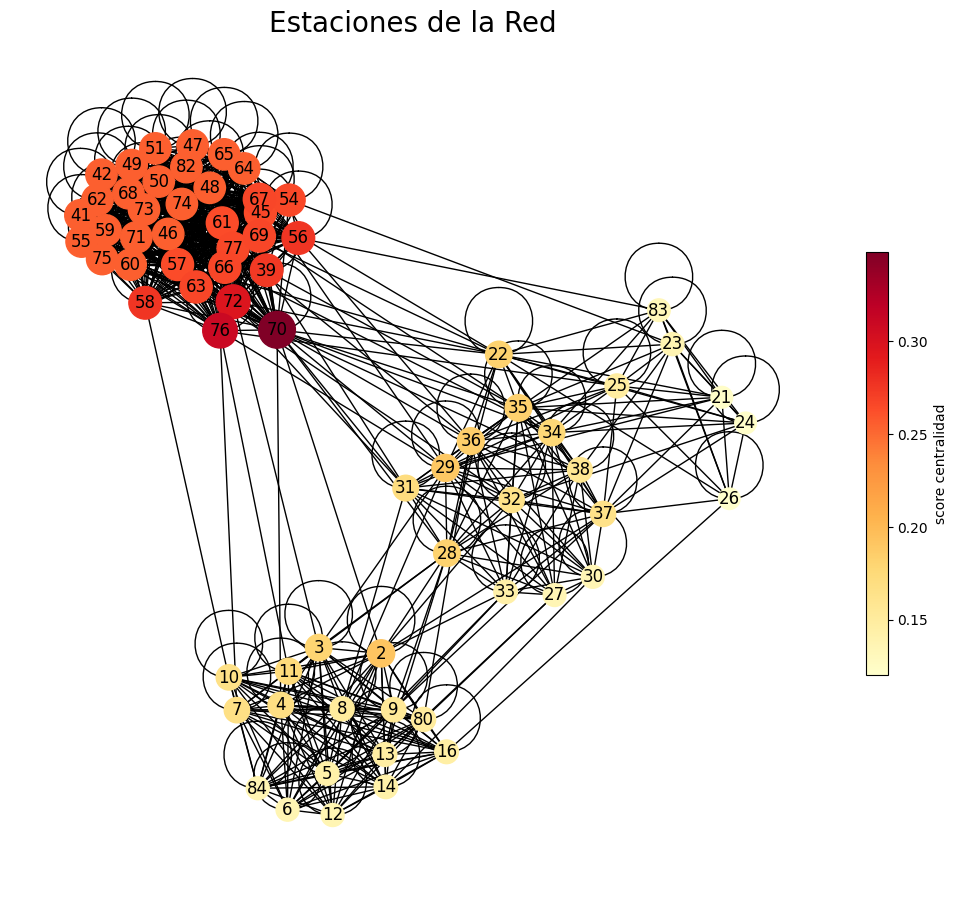

In [ ]:
# Graficar red de bicicletas donde se visualiza estaciones más importantes
pos = nx.spring_layout(G, seed=42)

# Tamañoy color del nodo con base en el valor del score de centralidad
node_sizes = [2000 * dict(centrality_df['score centralidad'])[node] for node in G.nodes()]
node_colors = [dict(centrality_df['score centralidad'])[node] for node in G.nodes()]
mynorm = plt.Normalize(vmin=min(node_colors), vmax=max(node_colors))

plt.figure(figsize=(13, 11))
plt.title('Estaciones de la Red', fontsize=20)
plt.grid()
plt.axis('off')
nx.draw(G, with_labels=True, node_size=node_sizes, node_color=node_colors, cmap='YlOrRd', pos=pos)
cbar = plt.colorbar(
    plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=mynorm),
    ax=plt.gca(),
    label='score centralidad',
    shrink=0.5
)
plt.show()

La imagen muestra un diagrama de red titulado "Estaciones de la Red" con las estaciones de bicicletas compartidas de San Francisco, pero ahora con colores que indican el nivel de centralidad o importancia de cada estación. Las estaciones están representadas por nodos numerados y conectados entre sí por líneas que muestran las posibles rutas.

- La escala de colores va desde amarillo claro (menor centralidad) hasta rojo oscuro/burdeos (mayor centralidad), según indica la barra lateral.
- El diagrama mantiene los tres clusters principales vistos anteriormente, pero ahora con información visual sobre su importancia.
- Las estaciones de la parte superior izquierda (cluster grande con números 41-77) muestran colores naranja a rojo intenso, indicando alta centralidad.
- Las estaciones 70, 72, 76 y 77 en este grupo son las que presentan el color más intenso (rojo oscuro), sugiriendo que son las más cruciales.
- Los otros dos clusters (en la parte inferior y derecha) muestran estaciones con tonos amarillos, indicando menor centralidad.

**Insights relevantes**

- Existe una clara jerarquía en la importancia de las estaciones dentro de la red, con las ubicadas en el centro/noreste de San Francisco (cluster superior izquierdo) siendo significativamente más centrales que el resto.
- Las estaciones con mayor score de centralidad (70, 72, 76) probablemente corresponden a nodos clave como las estaciones de Caltrain, BART o intersecciones importantes en Market Street, coincidiendo con lo que vimos en la tabla anterior.
- La concentración de estaciones de alta centralidad en un solo cluster sugiere que el sistema tiene un "núcleo fuerte" pero podría ser vulnerable a interrupciones en esa zona específica.
- Los otros dos clusters funcionan como "subcentros" con conexiones internas fuertes pero dependen de unas pocas conexiones clave con el cluster principal.
Esta visualización confirma la naturaleza policéntrica pero desequilibrada del sistema, con una clara zona dominante y zonas secundarias menos integradas.
- Las estaciones periféricas (números más bajos) generalmente tienen menor centralidad, pero algunas muestran valores intermedios, lo que sugiere que actúan como gateways importantes para sus respectivas zonas.
- Para mejorar la resiliencia del sistema, podría ser beneficioso fortalecer las conexiones entre clusters e incrementar la centralidad de estaciones en las zonas amarillas.


**En resumen**
- La estación "San Francisco Caltrain 2 (330 Townsend)" con id "70", tiene la mayor centralidad de grado, lo que indica que es la estación con mayor conexión a otras estaciones de la red.
- La estación "San Francisco Caltrain 2 (330 Townsend)" con id "70", tiene la mayor centralidad de intermediación, lo que indica que es la estación que funciona como puente entre las distintas zonas de la red.
- La estación "San Francisco Caltrain 2 (330 Townsend)" con id "70", tiene la mayor centralidad de cercanía, lo que indica que es la estación más eficiente para comunicarse con el resto de estaciones de la red.
- La estación "San Francisco Caltrain 2 (330 Townsend)" con id "70", tiene la mayor centralidad de eigenvector y PageRank, lo que indica que es la estación con conexión a estaciones con importante numero de conexiones.

### **3.3. Análisis de Comunidades**

En esta sección determinamos las columnidades de la red utilizando el método de Louvain.

#### **3.3.1. ¿Cuántas comunidades se pueden reconocer en la red?**

In [ ]:
# Determinar comunidades con el método Louvain
communities = community_louvain.best_partition(G, random_state=42)
nx.set_node_attributes(G, communities, 'group')
community = pd.DataFrame.from_dict(communities, orient='index', columns=['community']).reset_index()
community.columns =['start_station_id', 'community']
community.head()

,start_station_id,community
0,62,0
1,64,0
2,61,0
3,57,0
4,56,0


In [ ]:
# Número de comunidades encontradas
print("Número único de comunidades:", community['community'].nunique())

Número único de comunidades: 3


In [ ]:
# Asignamos la comunidad a cada ruta con base en la estación de inicio
merged_df = df.merge(community, on='start_station_id', how='left')
merged_df['community'] = merged_df.community.astype('object')
merged_df.head()

,start_station_name,start_station_id,start_station_lat,start_station_long,end_station_name,end_station_id,end_station_lat,end_station_long,trip_count,route,community
0,2nd at Folsom,62,37.785299,-122.396236,2nd at Folsom,62,37.785299,-122.396236,206,2nd at Folsom -to- 2nd at Folsom,0
1,2nd at Folsom,62,37.785299,-122.396236,2nd at South Park,64,37.782259,-122.392738,704,2nd at Folsom -to- 2nd at South Park,0
2,2nd at Folsom,62,37.785299,-122.396236,2nd at Townsend,61,37.780526,-122.390288,825,2nd at Folsom -to- 2nd at Townsend,0
3,2nd at Folsom,62,37.785299,-122.396236,5th at Howard,57,37.781752,-122.405127,323,2nd at Folsom -to- 5th at Howard,0
4,2nd at Folsom,62,37.785299,-122.396236,Beale at Market,56,37.792251,-122.397086,229,2nd at Folsom -to- Beale at Market,0


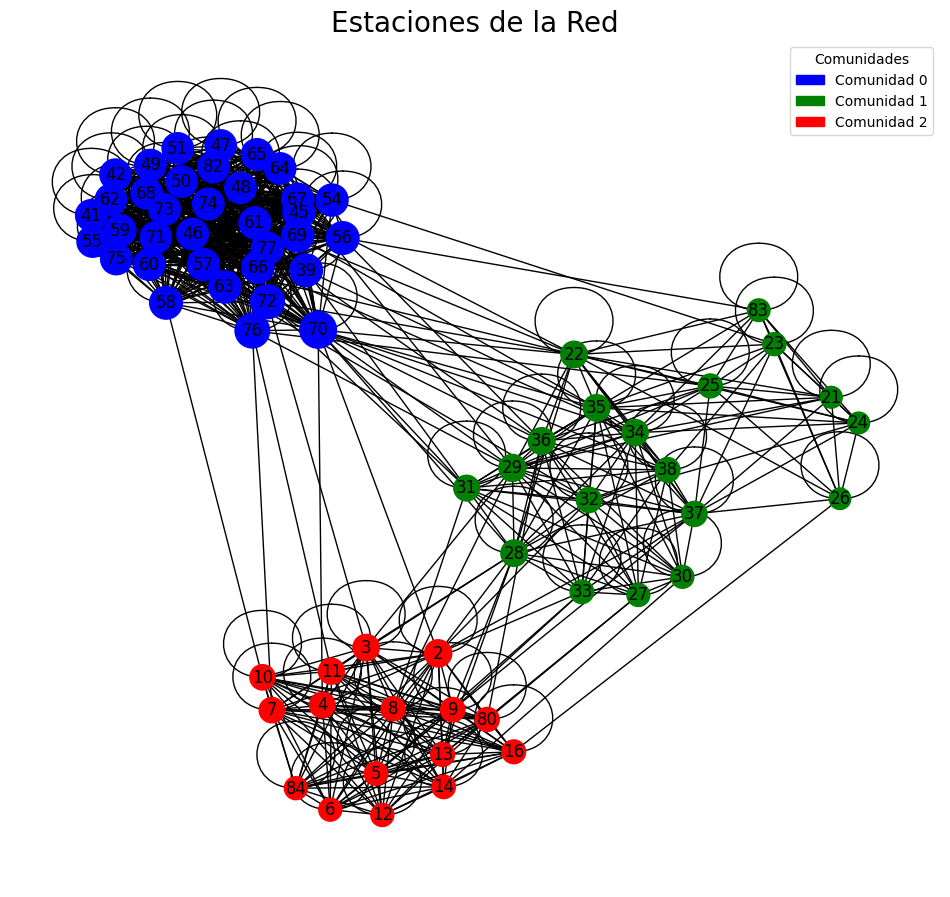

In [ ]:
# Graficar red de bicicletas donde se visualiza estaciones más importantes
pos = nx.spring_layout(G, seed=42)

# Tamaño del nodo con base en el valor del score de centralidad
node_sizes = [2000 * dict(centrality_df['score centralidad'])[node] for node in G.nodes()]

# Color del nodo con base en la comunidad
color_map = {0: "blue", 1: "green", 2:"red"}
node_colors = [color_map[{i: j for i, j in zip(community['start_station_id'], community['community'])}[node]] for node in G.nodes()]


# Crear los patches para la leyenda
legend_elements = [Patch(facecolor=color, edgecolor=color, label=f'Comunidad {key}') for key, color in color_map.items()]

plt.figure(figsize=(12, 11))
plt.title('Estaciones de la Red', fontsize=20)
plt.grid()
plt.axis('off')
nx.draw(G, with_labels=True, node_size=node_sizes, node_color=node_colors, pos=pos)
plt.legend(handles=legend_elements, loc='best', title='Comunidades')

plt.show()

La imagen muestra un diagrama donde se visualizan las estaciones de bicicletas compartidas en San Francisco, ahora organizadas por comunidades. El diagrama muestra una clara división en tres comunidades distintas, cada una representada con un color diferente según indica la leyenda:

- Comunidad 0 (azul): El gran cluster en la parte superior izquierda, que incluye las estaciones 41-77
- Comunidad 1 (verde): El cluster en la parte derecha central, que incluye estaciones como 21-38
- Comunidad 2 (rojo): El cluster en la parte inferior, que incluye estaciones como 2-16, 80, 84

**Insights relevantes**

- La red de bicicletas compartidas de San Francisco está naturalmente segmentada en tres comunidades distintas que probablemente corresponden a diferentes distritos o zonas geográficas de la ciudad (posiblemente el centro financiero/norte en azul, zona este/bahía en verde, y sur/Mission en rojo).
- Esta segmentación por comunidades confirma los patrones de movilidad intrazonales: los usuarios tienden a moverse principalmente dentro de la misma comunidad, con menos viajes entre diferentes comunidades.
- Las conexiones entre comunidades son más limitadas y estratégicas, lo que sugiere puntos específicos de transferencia entre zonas de la ciudad. Estas conexiones intercomunidades son cruciales para la conectividad global del sistema.
- La Comunidad 0 (azul) es la más grande y densamente conectada, lo que sugiere que es el núcleo del sistema, probablemente correspondiendo al centro de la ciudad y zonas de alta actividad comercial y turística.
- El análisis de comunidades revela una estructura jerárquica en la red: un núcleo principal (azul) y dos subcentros (verde y rojo) que funcionan como hubs secundarios para sus respectivas zonas.
- Esta estructura de comunidades podría utilizarse para:
  - Diseñar estrategias específicas de rebalanceo de bicicletas por comunidad
  Planificar expansiones del sistema que refuercen la conectividad inter-comunidades
  - Desarrollar tarifas o incentivos para fomentar viajes entre comunidades menos conectadas
- La claridad de la separación entre comunidades sugiere que hay barreras físicas (como colinas, grandes avenidas o discontinuidades urbanas) que afectan a los patrones de uso de las bicicletas compartidas en San Francisco.

In [ ]:
# Representamos las estaciones agrupadas en comunidades en el mapa de San Francisco
fig = px.scatter_mapbox(merged_df, lat='start_station_lat', lon='start_station_long', zoom=9,
                        mapbox_style="carto-positron", height=700,
                        hover_name='start_station_name', size='trip_count',
                        color='community',
                        color_discrete_map=color_map ,
                        title="Mapa de la Red de Bicicletas en San Francisco", opacity=0.5)
fig.update_layout(scattergap=0)
fig.show()

La imagen muestra un mapa con las estaciones agrupadas por comunidades según un análisis de red. Las comunidades están representadas con colores distintos: azul (comunidad 0), verde (comunidad 1) y rojo (comunidad 2).

- La comunidad 0 (azul) está concentrada en el centro/norte de San Francisco.
- La comunidad 1 (verde) se distribuye principalmente en la Península, con presencia en Palo Alto, Mountain View, Redwood City y algunas zonas intermedias.
- La comunidad 2 (rojo) está concentrada en San José, al sur de la Bahía.

**Insights relevantes**

- La visualización geográfica confirma que las comunidades de estaciones identificadas en el análisis de red corresponden a regiones geográficas distintas, lo que valida la metodología de detección de comunidades.
- Existe una clara separación geográfica entre las tres comunidades, con distancias considerables entre ellas, lo que explica la limitada conectividad entre clusters observada en los diagramas anteriores.
- La distribución espacial revela que el sistema de bicicletas compartidas del Área de la Bahía funciona efectivamente como tres subsistemas diferentes (San Francisco, Península y San José) con poca integración entre ellos.
- Esta segmentación geográfica refleja la realidad urbana de la región: San Francisco como núcleo denso, la Península con desarrollos más dispersos alrededor de centros tecnológicos, y San José como otro núcleo urbano al sur.
- Las distancias entre comunidades (aproximadamente 50 km entre San Francisco y San José) hacen inviable el uso de bicicletas para interconectarlas, explicando por qué hay pocas conexiones entre ellas en los diagramas de red.
- Esta estructura sugiere que el sistema está diseñado principalmente para:
  - Desplazamientos locales dentro de cada zona
  - Conexiones con transporte público para viajes interzonales (Caltrain, BART)
  - No para viajes directos entre las tres comunidades
- Para mejorar la integración del sistema, sería más efectivo fortalecer la intermodalidad con transporte público que intentar conectar directamente las tres comunidades con nuevas estaciones de bicicletas.


**En resumen**
- Las estaciones en San Francisco tienen el mayor número de viajes entre estaciones.
- Las estaciones localizadas en San Jose tienen el menor número de viajes entre estaciones.
- El método de Louvain permitió reconocer las tres comunidades claras que existen en la red de estaciones de bicicletas, badaso unicamente en la información de nodos y enlaces (viajes) de la red.

# **Caso Práctico 2: Análisis de Redes Sociales**
El documento corresponde a un caso práctico que puede ser utilizado como guía para aplicar Network Analysis en casos prácticos reales.

### **Contexto práctico**

La popularidad de las redes sociales y la cantidad de datos generados por las mismas, han permitido desarrollar metodologías de análisis para identificar actores clave y patrones en las relaciones. Estos actores y relaciones pueden ser de utilidad para desarrollar estrategias de negocio en distintas áreas. Los datos utilizados en este caso de uso corresponden a la forma mas simple de datos que se obtienen de una red social. Estos datos corresponden a una muestra de usuarios y seguidores en la red social Twitter. El objetivo es desarrollar una prueba de concepto para entender los actores principales y las comunidades que puedan existir en la muestra de la red social.

### **Descripción de los datos**

Los datos corresponden a 2 variables:

- **user**: usuario de la red social.
- **follower**: seguidor del usuario.

## **1. Configuración Inicial y Carga de Datos**
Primero, configuraremos nuestro entorno de análisis e importaremos las bibliotecas necesarias.

In [ ]:
# Importar librerias
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import networkx as nx
from community import community_louvain
from collections import defaultdict
import os

In [ ]:
# Descargar el dataset
path = kagglehub.dataset_download("mathurinache/twitter-edge-nodes")

100%|██████████| 342M/342M [00:03<00:00, 93.4MB/s]

Extracting files...


In [ ]:
# Carga el dataset de seguidores en twitter
data_paths = [os.path.join(pth, f)
    for pth, dirs, files in os.walk(path + "/" + os.listdir(path)[0]) for f in files]

df = pd.read_csv(data_paths[2], header=None, names=['user', 'follower'])
df.head()

,user,follower
0,1,11553
1,1,8762940
2,1,8762941
3,1,688136
4,1,8762942


## **2. Análisis Inicial**
Analizaremos la información inherente al dataset para entender:
- Tipos de datos
- Valores faltantes
- Número único de usuarios y conexiones

In [ ]:
# Mostrar información básica del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85331845 entries, 0 to 85331844
Data columns (total 2 columns):
 #   Column    Dtype
---  ------    -----
 0   user      int64
 1   follower  int64
dtypes: int64(2)
memory usage: 1.3 GB


In [ ]:
# Número único de usuarios y relaciones de follow (conexiones)
print("Número único de usuarios:", df['user'].nunique())
print("Número único de conexiones:", df.drop_duplicates().shape[0])

Número único de usuarios: 8768419
Número único de conexiones: 85331845


#### **Insights relevantes**
- No existen valores nulos
- Existen 8768419 usuarios únicos
- Existen 85331845 conexiones únicas entre usuarios

### **2.1. Muestro de Dataset**
Dado el tamaño del dataset realizaremos un muestreo de los usuarios para poder llevar a cabo el análisis.

In [ ]:
# Se toma una muestra del dataset
user_sample = list(df['user'].sample(n=500, random_state=42))
df_sample = df[(df['user'].isin(user_sample)) & (df['follower'].isin(user_sample))]

In [ ]:
# Número único de usuarios y relaciones de follow (conexiones)
print("Número único de usuarios:", df_sample['user'].nunique())
print("Número único de conexiones:", df_sample.drop_duplicates().shape[0])

Número único de usuarios: 342
Número único de conexiones: 10456


## **3. Network Analysis**

Dado que las redes son representaciones de enlaces entre dos nodos, los usuarios corresponderan a los nodos y cada relación de follow correspondera a una conexión o enlace. Asi, crearemos una red de usuarios, misma que analizaremos utilizando métricas de centralidad. Adicional, utilizaremos el método Louvain para la detección de comunidades.



### **3.1. Métricas de Centralidad**

En este caso iniciamos creando una representación de la red formada por usuarios y sus conexiones entre si. Continuaremos utilizando las métricas de centralidad para analizar a los principales actores.

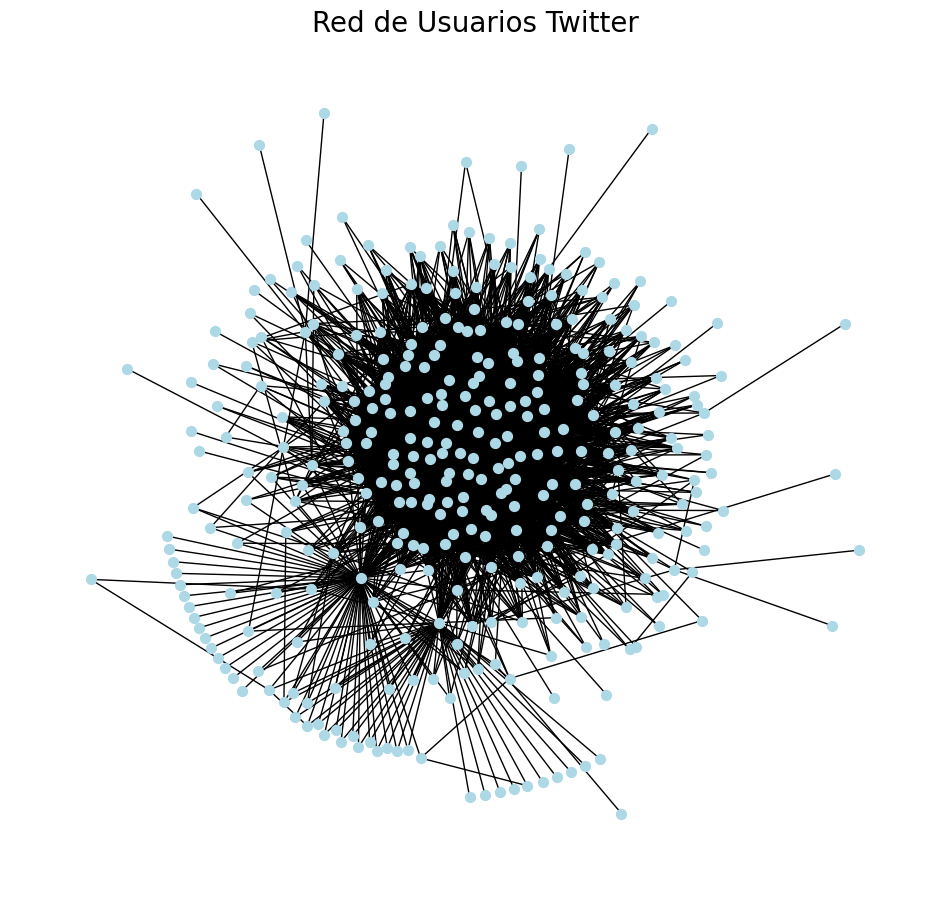

In [ ]:
# Crear y graficar red de bicicletas
G = nx.from_pandas_edgelist(df_sample, source='user', target='follower', create_using=nx.Graph())
pos = nx.kamada_kawai_layout(G)

plt.figure(figsize=(12, 11))
plt.title('Red de Usuarios Twitter', fontsize=20)
plt.grid()
plt.axis('off')
nx.draw(G, with_labels=False, node_color='lightblue', node_size=50, pos=pos)
plt.show()

La imagen muestra un diagrama que representa una red social de usuarios y sus conexiones. La visualización tiene forma de grafo, donde cada punto celeste representa a un usuario de Twitter y las líneas negras representan conexiones entre ellos (probablemente seguidores, menciones, retuits u otras interacciones).

- La red muestra una estructura radial con un núcleo densamente conectado en el centro.
- Hay aproximadamente cientos de nodos (usuarios) representados como puntos celestes.
- Se observa una concentración densa de conexiones en el centro, formando un "núcleo" donde los usuarios están altamente interconectados.
- Desde este núcleo se extienden conexiones hacia usuarios periféricos, que tienen menos conexiones y se ubican en los bordes del grafo.
- Algunos nodos periféricos muestran patrones de "rayos", donde un solo nodo central se conecta con múltiples nodos externos.

**Insights relevantes**

- La red muestra una estructura típica de "núcleo-periferia", característica de muchas redes sociales, donde un grupo central de usuarios influyentes mantiene la mayoría de las conexiones mientras que los usuarios periféricos tienen menos vínculos.
- Esta estructura sugiere la presencia de "líderes de opinión" o "influencers" en el centro de la red, que probablemente son los que generan mayor contenido compartido, tienen más seguidores o participan más activamente en conversaciones.
- La densidad de conexiones en el núcleo indica una comunidad cohesiva donde la información puede propagarse rápidamente, mientras que los usuarios periféricos están más aislados y probablemente reciben información con retraso.
- Los patrones radiales en algunas áreas sugieren "micro-influencers" que tienen su propio grupo de seguidores pero están conectados al núcleo principal.
- La estructura refleja la naturaleza desigual de la influencia en redes sociales: pocos usuarios acumulan la mayoría de las conexiones mientras que muchos tienen relativamente pocas.
- A diferencia de la red de bicicletas que vimos anteriormente, esta red no muestra una clara división en comunidades separadas, sino una estructura más centralizada, lo que sugiere una conversación o tema unificado.
- Esta visualización podría ser útil para identificar usuarios clave para campañas de marketing, detectar la propagación de información o desinformación, o entender dinámicas de formación de opinión en torno a un tema específico en Twitter.

#### **3.2.1. ¿Cuáles son los usuarios mas relevantes?**
Para responder esta pregunta utilizaremos las métricas de centralidad. Crearemos un score de centralidad que corresponde al promedio de las medidas de centralidad calculadas.

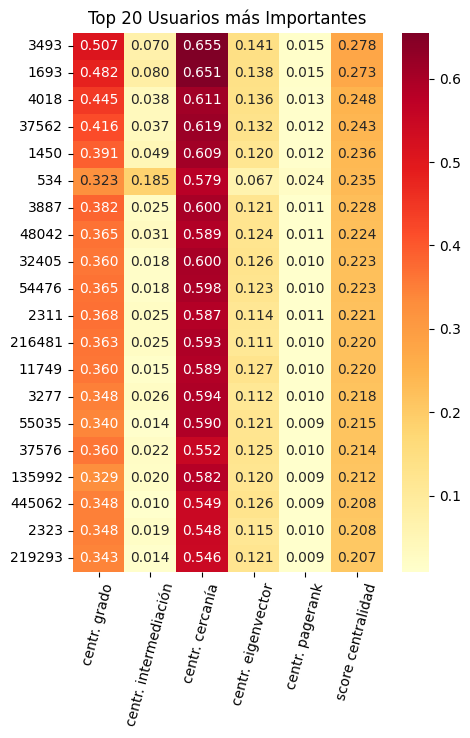

In [ ]:
def analyze_centrality(G):
    """
    Análisis completo usando múltiples métricas
    """
    # Calculamos diferentes méticas de centralidad
    metrics = {
        'centr. grado': nx.degree_centrality(G),
        'centr. intermediación': nx.betweenness_centrality(G),
        'centr. cercanía': nx.closeness_centrality(G),
        'centr. eigenvector': nx.eigenvector_centrality(G),
        'centr. pagerank': nx.pagerank(G)
    }

    # Creamos DataFrame con métricas
    centrality_df = pd.DataFrame(metrics)

    # Calculamos score compuesto
    centrality_df['score centralidad'] = centrality_df.mean(axis=1)

    return centrality_df

# Analizamos rede de bicicletas
centrality_df = analyze_centrality(G)

# Visualización de top influencers
plt.figure(figsize=(5, 7))
top_stations = centrality_df.nlargest(20, 'score centralidad')
sns.heatmap(top_stations, cmap='YlOrRd', annot=True, fmt=".3f", annot_kws={"fontsize":10})
plt.title('Top 20 Usuarios más Importantes')
plt.xticks(rotation=75)
plt.show()

La imagen muestra un mapa de calor que analiza las métricas de centralidad para los usuarios más influyentes en la red de Twitter. Al igual que vimos con las estaciones de bicicletas, se utilizan diferentes medidas de centralidad para evaluar la importancia de cada usuario en la red.

- La visualización presenta a los 20 usuarios más relevantes, identificados por sus IDs numéricos (como 3493, 1693, 4018, etc.).
- Las métricas incluyen: centralidad de grado, intermediación, cercanía, eigenvector, PageRank y score centralidad.
- La escala de colores va desde amarillo claro (valores más bajos) hasta rojo oscuro/burdeos (valores más altos).
- Los usuarios están ordenados por su importancia general en la red, con el usuario 3493 encabezando la lista.

**Insights relevantes**

- El usuario 3493 destaca significativamente como el más influyente, con valores superiores en casi todas las métricas, especialmente en centralidad de grado (0.507) y cercanía (0.655), lo que indica que está extremadamente bien conectado y puede difundir información con gran eficiencia.
- La centralidad de cercanía muestra valores consistentemente altos (>0.54) para todos los usuarios del top 20, lo que sugiere que estos influencers están bien posicionados para difundir información rápidamente a través de la red.
- El usuario 534 (sexto en la lista) muestra un patrón interesante: tiene un valor de intermediación excepcionalmente alto (0.185) en comparación con los demás, lo que indica que este usuario sirve como "puente" crítico entre diferentes comunidades que de otro modo estarían menos conectadas.
- En general, los valores de centralidad de grado son bastante altos para estos usuarios (entre 0.323 y 0.507), mostrando que tienen muchas conexiones directas, consistente con su rol de influencers.
- Los valores de PageRank son relativamente bajos en comparación con otras métricas, lo que podría indicar que aunque estos usuarios son importantes, no monopolizan completamente la atención de la red.
- Existe una correlación visible entre las diferentes métricas, pero no es perfecta, lo que demuestra que cada medida captura aspectos distintos de la influencia en la red.
- Esta información podría utilizarse para:
  - Identificar a los principales amplificadores de información/desinformación
  - Seleccionar usuarios estratégicos para campañas de marketing o información
  - Entender cómo la red dependería de ciertos usuarios clave para la difusión de contenido
  - Detectar posibles "guardianes" (gatekeepers) de información representados por usuarios con alta intermediación
- A diferencia de la red de bicicletas que mostraba diferentes comunidades geográficas, esta red Twitter parece estar más centralizada alrededor de unos pocos usuarios muy influyentes, reflejando la naturaleza más jerárquica de las interacciones en redes sociales.

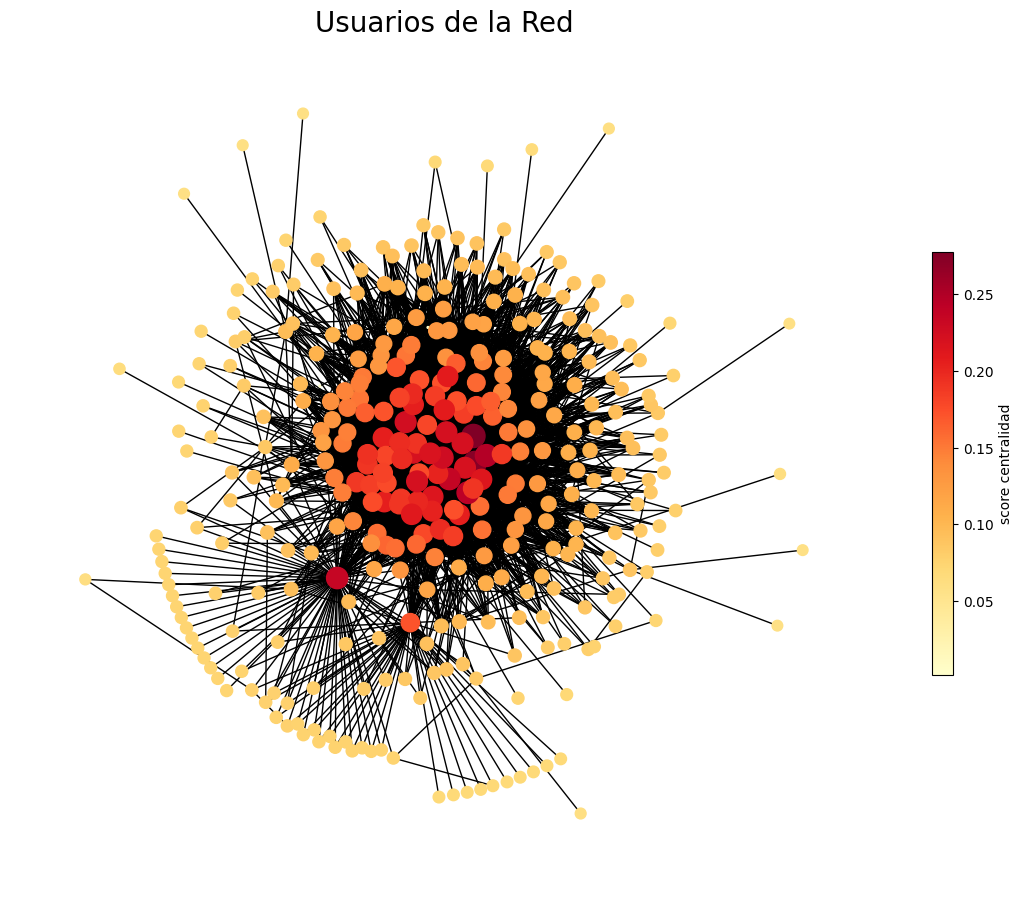

In [ ]:
# Graficar red de bicicletas donde se visualiza estaciones más importantes
pos = nx.kamada_kawai_layout(G)

# Tamañoy color del nodo con base en el valor del score de centralidad
node_sizes = [1000 * dict(centrality_df['score centralidad'])[node] for node in G.nodes()]
node_colors = [dict(centrality_df['score centralidad'])[node] for node in G.nodes()]
mynorm = plt.Normalize(vmin=min(node_colors), vmax=max(node_colors))

plt.figure(figsize=(14, 11))
plt.title('Usuarios de la Red', fontsize=20)
plt.grid()
plt.axis('off')
nx.draw(G, with_labels=False, node_size=node_sizes, node_color=node_colors, cmap='YlOrRd', pos=pos)
cbar = plt.colorbar(
    plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=mynorm),
    ax=plt.gca(),
    label='score centralidad',
    shrink=0.5
)
plt.show()

La imagen muestra un diagrama que visualiza la misma red de Twitter que vimos anteriormente, pero ahora con los nodos (usuarios) coloreados según su nivel de centralidad o importancia. La escala de colores va desde amarillo claro (menor centralidad, con valores cercanos a 0) hasta rojo oscuro/burdeos (mayor centralidad, con valores superiores a 0.25).

- El grafo mantiene la estructura radial vista anteriormente, pero ahora la importancia de cada usuario se identifica por color.
- Se observa un núcleo central de usuarios con colores rojo intenso y burdeos, que representan a los más influyentes.
- A medida que nos alejamos del centro, los colores cambian gradualmente a naranja y finalmente a amarillo claro en la periferia.
- Destacan especialmente algunos nodos de color rojo intenso, que probablemente corresponden a los usuarios top que vimos en la tabla anterior (como el usuario 3493).
- La estructura general muestra un gradiente concéntrico de influencia desde el centro hacia el exterior.

**Insights relevantes**

- La visualización confirma una clara jerarquía de influencia en la red, con un pequeño núcleo de usuarios extremadamente centrales (rojo oscuro) que probablemente dominan la conversación o el flujo de información.
- La gradación de colores desde el centro hacia afuera revela una distribución de poder que sigue un patrón aproximadamente concéntrico, típico de redes con estructura "núcleo-periferia".
- Se observan algunos nodos rojos que aparecen fuera del núcleo central, lo que sugiere la presencia de sub-influencers importantes que, aunque no están en el centro absoluto de la red, mantienen posiciones de considerable influencia.
- El patrón de conexiones desde los nodos de alta centralidad (rojos) hacia los periféricos (amarillos) sugiere una estructura de información en cascada, donde la información fluye desde los usuarios centrales hacia los externos.
- La visualización revela que aproximadamente el 80-90% de los usuarios (nodos amarillos) tienen una centralidad muy baja, mientras que solo alrededor del 5-10% (nodos naranjas a rojos) concentran la mayoría de la influencia.
- Esta distribución desigual ilustra la "ley de potencia" típica en redes sociales, donde la influencia no se distribuye uniformemente sino que sigue un patrón donde "el 20% de los usuarios genera el 80% del impacto".
- A diferencia de la red de bicicletas que mostraba comunidades geográficas distintas, esta red de Twitter muestra una estructura más unificada alrededor de un tema o conversación, con capas de influencia que disminuyen desde el centro hacia el exterior.
- Esta información sería valiosa para estrategias de marketing de influencers, monitoreo de desinformación, o para entender cómo se propaga la información en esta comunidad específica de Twitter.

**En resumen**
- El usuario 3493, tiene la mayor centralidad de grado, lo que indica que es el usuario con mayor número de conexiones.
- El usuario 534, tiene la mayor centralidad de intermediación, lo que indica que es el usuario que funciona como puente entre las distintas comunidades de la red social.
- El usuario 3493, tiene la mayor centralidad de cercanía, lo que indica que es el usuario más eficiente para comunicarse el resto de usuarios de la red social.
- El usuario 3493, tiene la mayor centralidad de eigenvector y PageRank, lo que indica que el usuario con conexión a usuarios con importante numero de conexiones en la red social.

### **3.3. Análisis de Comunidades**

En esta sección determinamos las columnidades de la red utilizando el método de Louvain.

#### **3.3.1. ¿Cuántas comunidades se pueden reconocer en la red?**

In [ ]:
# Determinar comunidades con el método Louvain
communities = community_louvain.best_partition(G, random_state=100)
nx.set_node_attributes(G, communities, 'group')
community = pd.DataFrame.from_dict(communities, orient='index', columns=['community']).reset_index()
community.columns =['user', 'community']
community.head()

,user,community
0,94174,0
1,732,0
2,206922,0
3,534,0
4,230508,0


In [ ]:
# Número de comunidades encontradas
print("Número único de comunidades:", community['community'].nunique())

Número único de comunidades: 8


In [ ]:
# Asignamos la comunidad a cada ruta con base en la estación de inicio
merged_df = df_sample.merge(community, on='user', how='left')
merged_df['community'] = merged_df.community.astype('object')
merged_df.head()

,user,follower,community
0,94174,732,0
1,206922,534,0
2,230508,534,0
3,264599,732,0
4,439937,48042,1


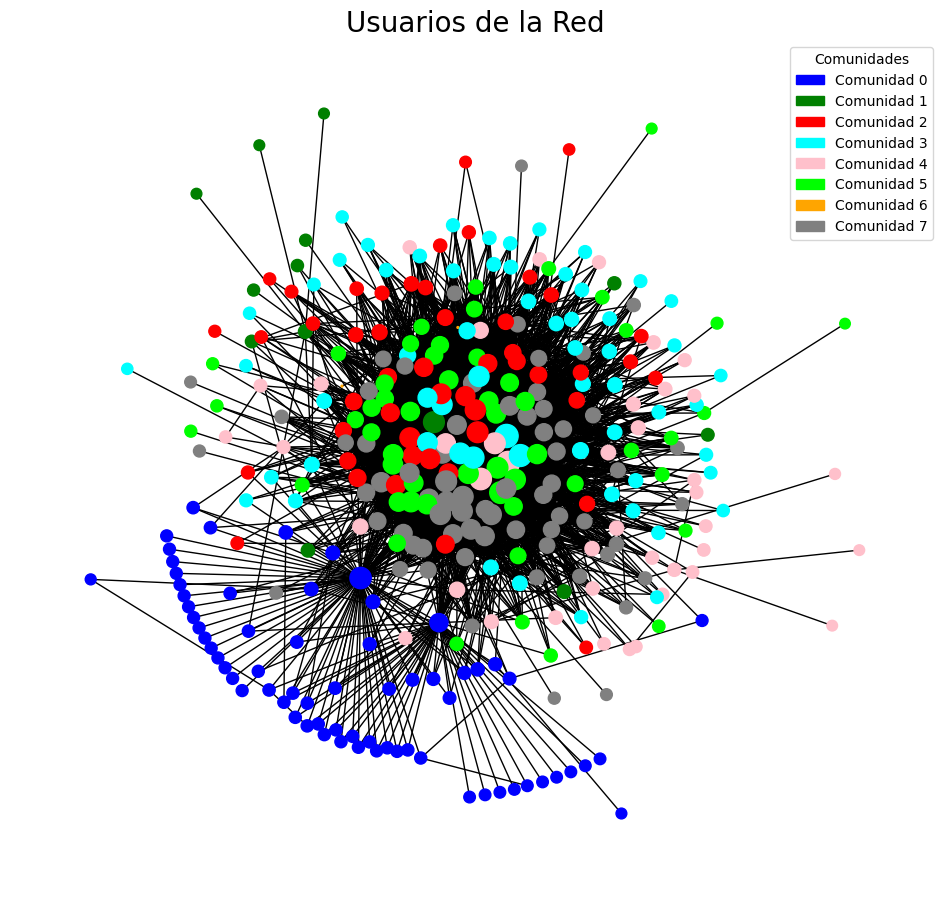

In [ ]:
# Graficar red de bicicletas donde se visualiza estaciones más importantes
pos = nx.kamada_kawai_layout(G)

# Tamaño del nodo con base en el valor del score de centralidad
node_sizes = [1000 * dict(centrality_df['score centralidad'])[node] for node in G.nodes()]

# Color del nodo con base en la comunidad
color_map = {0: "blue", 1: "green", 2:"red", 3:"cyan", 4: "pink", 5: "lime", 6: "orange", 7: "grey"}
node_colors = [color_map[{i: j for i, j in zip(community['user'], community['community'])}[node]] for node in G.nodes()]

# Crear los patches para la leyenda
legend_elements = [Patch(facecolor=color, edgecolor=color, label=f'Comunidad {key}') for key, color in color_map.items()]

plt.figure(figsize=(12, 11))
plt.title('Usuarios de la Red', fontsize=20)
plt.grid()
plt.axis('off')
nx.draw(G, with_labels=False, node_size=node_sizes, node_color=node_colors, pos=pos)
plt.legend(handles=legend_elements, loc='best', title='Comunidades')
plt.show()

La imagen muestra un diagrama que representa la misma red de Twitter vista anteriormente, pero ahora con los nodos (usuarios) agrupados y coloreados según comunidades. Se identifican 8 comunidades distintas (de 0 a 7) representadas con diferentes colores según indica la leyenda.

- El grafo mantiene la estructura radial general, pero ahora los usuarios están clasificados en comunidades específicas.
- Las comunidades se distinguen claramente por colores: azul (0), verde oscuro (1), rojo (2), celeste (3), rosa (4), verde claro (5), naranja (6) y gris (7).
- La Comunidad 0 (azul) destaca especialmente en la parte inferior del grafo, formando un segmento semicircular bastante cohesivo.
- Las demás comunidades parecen entremezclarse más en el núcleo central de la red.
Algunas comunidades muestran patrones de distribución específicos, sugiriendo diferentes roles o posiciones en la red.

**Insights relevantes**

- La detección de comunidades revela que, a diferencia de lo que podría parecer a simple vista, la red de Twitter no es homogénea sino que está estructurada en subgrupos con mayor interconexión interna.
- La Comunidad 0 (azul) muestra un patrón muy distintivo, con usuarios ubicados principalmente en la periferia y formando un arco en la parte inferior. Este patrón sugiere un grupo específico de usuarios que interactúan principalmente entre sí y tienen conexiones limitadas con el núcleo central.
- Las comunidades que ocupan el centro de la red (principalmente grises, verdes claros, rojos y celestes) probablemente representan grupos temáticos o de interacción que están más integrados en la conversación general.
- La presencia de múltiples comunidades en el núcleo central sugiere que, aunque hay divisiones temáticas o sociales, existe un considerable intercambio de información entre diferentes grupos.

- Esta estructura de comunidades podría reflejar divisiones basadas en:
  - Intereses temáticos (grupos que hablan sobre temas específicos)
  - Afiliaciones políticas o ideológicas
  - Características demográficas o geográficas
  - Patrones temporales de actividad

- A diferencia de la red de bicicletas que mostraba una clara separación geográfica entre comunidades, esta red muestra comunidades más entremezcladas, lo que sugiere que las fronteras entre grupos son más permeables en este contexto digital.

- Esta visualización sería valiosa para:

  - Identificar grupos de opinión o "burbujas" de información
  - Entender cómo diferentes narrativas podrían circular dentro de subgrupos específicos
  - Detectar usuarios "puente" que conectan diferentes comunidades
  - Diseñar estrategias de comunicación dirigidas a comunidades específicas

- La coexistencia de comunidades distintas pero interconectadas ilustra la naturaleza compleja de las conversaciones en redes sociales, donde se forman grupos de afinidad pero mantienen cierto nivel de interacción entre ellos.

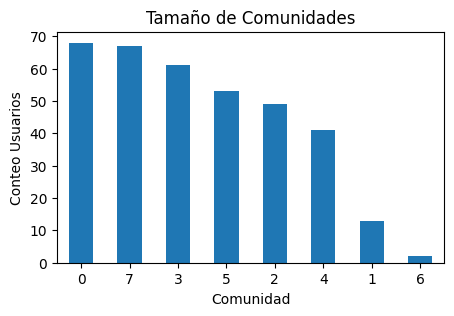

In [ ]:
# Tamaño de comunidades
community_sizes = pd.Series(community['community']).value_counts()

plt.figure(figsize=(5, 3))
community_sizes.plot(kind='bar')
plt.title('Tamaño de Comunidades')
plt.xticks(rotation=0)
plt.xlabel("Comunidad")
plt.ylabel("Conteo Usuarios")
plt.show()

La imagen muestra un diagrama de barras que representa el número de usuarios en cada comunidad de la red de Twitter que hemos estado analizando.

- El eje X muestra el número de identificación de cada comunidad (0-7).
- El eje Y muestra el "Conteo Usuarios", indicando cuántos usuarios pertenecen a cada comunidad.
- Las comunidades están ordenadas de mayor a menor según su tamaño.
- La Comunidad 0 y la Comunidad 7 son las más grandes, con aproximadamente 68 usuarios cada una.
- La Comunidad 6 es la más pequeña, con apenas 2 usuarios.

**Insights relevantes**

- Existe una distribución desigual de usuarios entre las comunidades, con las comunidades 0 y 7 dominando la red en términos de tamaño.
- La Comunidad 0, que en la visualización anterior vimos que formaba un arco distintivo en la parte inferior del grafo, es una de las más numerosas, lo que refuerza su importancia como subgrupo cohesivo.
- La distribución sigue aproximadamente un patrón escalonado, con dos comunidades grandes (0 y 7), tres medianas (3, 5 y 4), y dos pequeñas (1 y 6).
- Las comunidades 1 y 6 son significativamente más pequeñas, lo que podría indicar nichos específicos de interés o grupos emergentes/residuales en la conversación.
- Esta distribución de tamaños sugiere una estructura social típica, donde algunos grupos grandes dominan el discurso mientras coexisten con grupos más pequeños y especializados.
- En comparación con la red de bicicletas que vimos anteriormente, esta red muestra mayor fragmentación en comunidades de diversos tamaños, lo que refleja la naturaleza más compleja de las interacciones sociales digitales comparadas con patrones de movilidad física.
- La presencia de comunidades pequeñas pero identificables (como la 1 y 6) sugiere que incluso grupos minoritarios pueden mantener cohesión e identidad dentro de la red más amplia.
- Desde una perspectiva de análisis de influencia, sería interesante cruzar esta información con los datos de centralidad para determinar si las comunidades más grandes también contienen a los usuarios más influyentes, o si existen comunidades pequeñas pero con alta influencia.


Estadísticas de Roles:

Puente:
Número de nodos: 36
Métricas promedio:
- degree: 0.319
- pagerank: 0.010
- betweenness: 0.029
- eigenvector: 0.106
- clustering: 0.397

Lider Engagement:
Número de nodos: 34
Métricas promedio:
- degree: 0.345
- pagerank: 0.010
- betweenness: 0.026
- eigenvector: 0.117
- clustering: 0.418

Influencer:
Número de nodos: 31
Métricas promedio:
- degree: 0.350
- pagerank: 0.010
- betweenness: 0.022
- eigenvector: 0.120
- clustering: 0.428

Superposición de Roles:
Lider engagement ∩ Puente: 28 nodos
Influencer ∩ Puente: 26 nodos
Influencer ∩ Lider engagement: 31 nodos


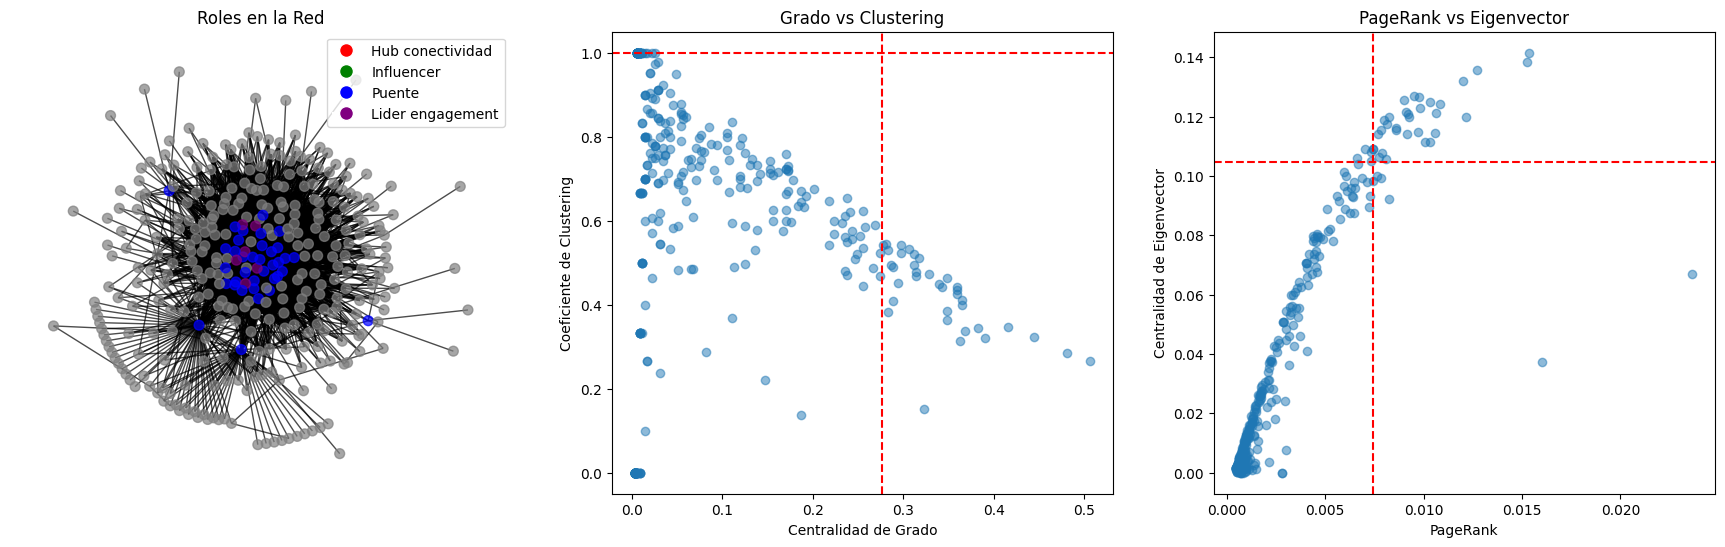

In [ ]:
def analyze_network_roles(G, percentile_threshold=90):
    """
    Analiza los roles de los nodos basados en diferentes métricas de centralidad

    Parámetros:
    - G: grafo NetworkX
    - percentile_threshold: percentil para determinar umbrales (default 90)
    """
    # Calculamos diferentes métricas de centralidad
    metrics = {
        'degree': nx.degree_centrality(G),
        'pagerank': nx.pagerank(G),
        'betweenness': nx.betweenness_centrality(G),
        'eigenvector': nx.eigenvector_centrality(G),
        'clustering': nx.clustering(G)
    }

    # Convertimos a DataFrame para facilitar análisis
    metrics_df = pd.DataFrame(metrics)

    # Calculamos umbrales para cada métrica
    thresholds = {
        metric: np.percentile(list(values.values()), percentile_threshold)
        for metric, values in metrics.items()
    }

    # Identificamos roles
    roles = defaultdict(list)

    for node in G.nodes():
        # Hub de conectividad: alto grado y alto clustering
        if (metrics['degree'][node] > thresholds['degree'] and
            metrics['clustering'][node] > thresholds['clustering']):
            roles['Hub conectividad'].append(node)

        # Influencer: alto pagerank y alto eigenvector
        if (metrics['pagerank'][node] > thresholds['pagerank'] and
            metrics['eigenvector'][node] > thresholds['eigenvector']):
            roles['Influencer'].append(node)

        # Puente: alta intermediación y bajo clustering
        if (metrics['betweenness'][node] > thresholds['betweenness'] and
            metrics['clustering'][node] < np.median(list(metrics['clustering'].values()))):
            roles['Puente'].append(node)

        # Líder de engagement: alto grado y alto pagerank
        if (metrics['degree'][node] > thresholds['degree'] and
            metrics['pagerank'][node] > thresholds['pagerank']):
            roles['Lider engagement'].append(node)

    # Visualización
    fig, axes = plt.subplots(1, 3, figsize=(22, 6))

    # 1. Red con roles coloreados
    pos = nx.kamada_kawai_layout(G)
    colors = []
    role_colors = {
        'Hub conectividad': 'red',
        'Influencer': 'green',
        'Puente': 'blue',
        'Lider engagement': 'purple'
    }

    # Asignamos colores a nodos según sus roles
    node_colors = []
    for node in G.nodes():
        node_roles = [role for role, nodes in roles.items() if node in nodes]
        if len(node_roles) > 0:
            node_colors.append(role_colors[node_roles[0]])  # Usamos el primer rol
        else:
            node_colors.append('gray')

    nx.draw(G, pos, node_color=node_colors,
            node_size=50, alpha=0.7, ax=axes[0])

    # Añadimos leyenda
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                markerfacecolor=color, label=role,
                                markersize=10)
                      for role, color in role_colors.items()]
    axes[0].legend(handles=legend_elements)
    axes[0].set_title('Roles en la Red')

    # 2. Scatter plot: Grado vs Clustering
    axes[1].scatter(metrics_df['degree'], metrics_df['clustering'],
                    alpha=0.5)
    axes[1].axvline(thresholds['degree'], color='r', linestyle='--')
    axes[1].axhline(thresholds['clustering'], color='r', linestyle='--')
    axes[1].set_xlabel('Centralidad de Grado')
    axes[1].set_ylabel('Coeficiente de Clustering')
    axes[1].set_title('Grado vs Clustering')

    # 3. Scatter plot: PageRank vs Eigenvector
    axes[2].scatter(metrics_df['pagerank'], metrics_df['eigenvector'],
                    alpha=0.5)
    axes[2].axvline(thresholds['pagerank'], color='r', linestyle='--')
    axes[2].axhline(thresholds['eigenvector'], color='r', linestyle='--')
    axes[2].set_xlabel('PageRank')
    axes[2].set_ylabel('Centralidad de Eigenvector')
    axes[2].set_title('PageRank vs Eigenvector')

    # Imprimimos estadísticas de roles
    print("\nEstadísticas de Roles:")
    for role, nodes in roles.items():
        print(f"\n{role.replace('_', ' ').title()}:")
        print(f"Número de nodos: {len(nodes)}")
        if len(nodes) > 0:
            print("Métricas promedio:")
            role_metrics = metrics_df.loc[nodes].mean()
            for metric, value in role_metrics.items():
                print(f"- {metric}: {value:.3f}")

    # Análisis adicional: superposición de roles
    print("\nSuperposición de Roles:")
    for role1, nodes1 in roles.items():
        for role2, nodes2 in roles.items():
            if role1 < role2:  # Evitamos duplicados
                overlap = set(nodes1) & set(nodes2)
                if len(overlap) > 0:
                    print(f"{role1} ∩ {role2}: {len(overlap)} nodos")

    return roles

# Analizamos roles
roles = analyze_network_roles(G)

Para determinar los roles en las comunidades se utulizaron las siguientes metricas: centralidad de grado, intermediación, eigenvector, pagerank y el coeficiente de clustering. Para todas las métricas se aplica como umbral de separación el percentil 90. Con base a este umbral se deferencian los roles principales de los usuarios comunes. En la práctica este umbral puede tomar cualquier valor de acuerdo a las resultados esperados del análisis realizado. Para este ejemplo los roles definidos fueron:

- **Hub conectividad**: alta centralidad de grado y alto coeficiente de clustering
- **Influencer**: alta centralidad PageRank y alta centralidad eigenvector
- **Puente**: alta centralidad de intermediación y bajo coeficiente de clustering
- **Lider engagement**: alta centralidad de grado y alta centralidad PageRank

La imagen presenta tres visualizaciones relacionadas con el análisis de roles y métricas en la red de Twitter.

- Roles en la Red (izquierda): Muestra el grafo de la red con los usuarios coloreados según su rol funcional: Hub de conectividad (rojo), Influencer (verde), Puente (azul) y Líder de engagement (morado). La mayoría de usuarios aparecen en gris (sin rol específico), mientras que los usuarios con roles especiales se concentran principalmente en el centro de la red.
- Grado vs Clustering (centro): Un diagrama de dispersión que relaciona la centralidad de grado (eje X) con el coeficiente de clustering (eje Y). Se observa una tendencia general de disminución del coeficiente de clustering a medida que aumenta la centralidad de grado. La línea roja vertical marca un umbral aproximado de 0.3 para la centralidad de grado.
- PageRank vs Eigenvector (derecha): Un diagrama de dispersión que correlaciona el PageRank (eje X) con la centralidad de eigenvector (eje Y). Muestra una relación positiva entre ambas métricas, con líneas rojas que marcan umbrales aproximados de 0.005 para PageRank y 0.105 para eigenvector.

**Insights relevantes**

- Especialización de roles: la visualización de roles muestra que solo una pequeña fracción de usuarios desempeña roles específicos en la red, principalmente concentrados en el núcleo. Esto confirma la naturaleza elitista de la influencia en redes sociales.
- Relación inversa entre grado y clustering: el gráfico central revela que los usuarios con mayor centralidad de grado (más conexiones) tienden a tener menor coeficiente de clustering. Esto sugiere que los usuarios más conectados sirven como "hubs" que enlazan diferentes grupos que de otro modo no estarían conectados, mientras que los usuarios con alto clustering pertenecen a comunidades más cohesivas pero menos centrales.
- Correlación entre diferentes métricas de influencia: el gráfico PageRank vs Eigenvector muestra una correlación positiva pero no perfecta, indicando que estas métricas capturan aspectos distintos pero relacionados de la influencia. Los usuarios ubicados en la esquina superior derecha son los influencers más poderosos según ambas métricas.
- Distribución no lineal de la influencia: ambos diagramas de dispersión muestran distribuciones no lineales, con pocos usuarios en los extremos superiores de las métricas y la mayoría concentrados en valores más bajos, confirmando la distribución de "ley de potencia" típica en redes sociales.
- Umbrales de influencia: las líneas rojas punteadas parecen marcar umbrales para identificar usuarios con roles específicos, sugiriendo que estos roles se determinan algorítmicamente en base a valores críticos de centralidad.
- Complementariedad de las métricas: El análisis muestra que diferentes métricas capturan distintos aspectos de la influencia, justificando el uso de múltiples indicadores para identificar roles específicos en la red.
- Implicaciones prácticas: esta clasificación de roles podría utilizarse para estrategias de marketing dirigido, donde los "hubs de conectividad" serían ideales para difusión amplia, los "puentes" para conectar comunidades, y los "líderes de engagement" para generar interacción profunda con contenidos.
